In [1]:
# Python libraries
import os
import sys
import pandas as pd # for data manipulation
import numpy as np # for data manipulation
import keras
import matplotlib.pyplot as plt

# To enable LaTeX and select a font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Import custom functions from other notebooks
sys.path.append("myfun/")
from ipynb.fs.full.myfun_density import *

2024-02-21 10:38:01.411151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 10:38:01.411179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 10:38:01.411988: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 10:38:01.417491: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 10:38:02.186058: W tensorflow/compiler/tf2

# Traffic flow: the LWR model

In [2]:
## Params
Nx = 100
Nt = 201
T = .5

rho_l = 0.8
rho_r = 0.4

In [3]:
## Flux
#Traffic Jam
f = lambda rho: rho*(1-rho)  
fprime = lambda rho: 1-2*rho
fprime_inv = lambda rho: .5*(1-rho)

# params
toll = 1e-3
flux = [f, fprime, fprime_inv]

In [4]:
# Space - linearly distributed
dx = 1/int(Nx/3)
a = np.linspace(-1,0,int(Nx/3))
b = np.linspace(0+dx/2, 1, Nx-int(Nx/3))
xspan = np.concatenate([a, b])

# Time
tspan = np.linspace(0,T,Nt)
tspan_rounded = list(np.round(tspan,2))

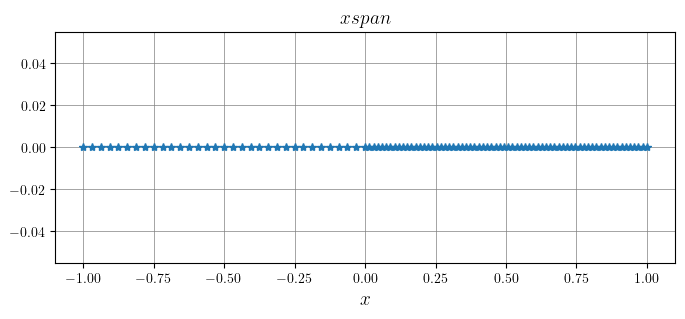

In [5]:
# Initialize the fig
fig, ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(xspan,xspan*0,marker='*', ls='None')

ax.set_xlabel(r"$x$",fontsize=14)
ax.set_title(fr"$xspan$",fontsize=14)
ax.grid(color='grey', linestyle='-', linewidth=0.5)
    
plt.show()

In [6]:
# Shock
speed_shock = (f(rho_r) - f(rho_l))/(rho_r - rho_l)

# Lax-Entropy condition
if fprime(rho_l) < speed_shock or fprime(rho_r) > speed_shock:
    print("Lax-Entropy condition not satisfied")

speed_shock, (f(rho_r),f(rho_l)), (fprime(rho_l), fprime(rho_r))

Lax-Entropy condition not satisfied


(-0.20000000000000004,
 (0.24, 0.15999999999999998),
 (-0.6000000000000001, 0.19999999999999996))

In [7]:
# Characteristics
chars = characteristic(xspan, tspan, rho_l, rho_r, flux, toll)
chars_transposed = list(map(list, zip(*chars)))

# Cars trajectories
cars_trajs = cars_trajectories(xspan, tspan, rho_l, rho_r, flux)
cars_trajs_transposed = list(map(list, zip(*cars_trajs)))

# Plot

In [8]:
## Plot params
# Plot 1
t_plot = T/2
idx_t_plot = tspan_rounded.index(t_plot)

# Plot 2
trange = 0, T/2, T
idx = [tspan_rounded.index(t) for t in trange]

## Plot

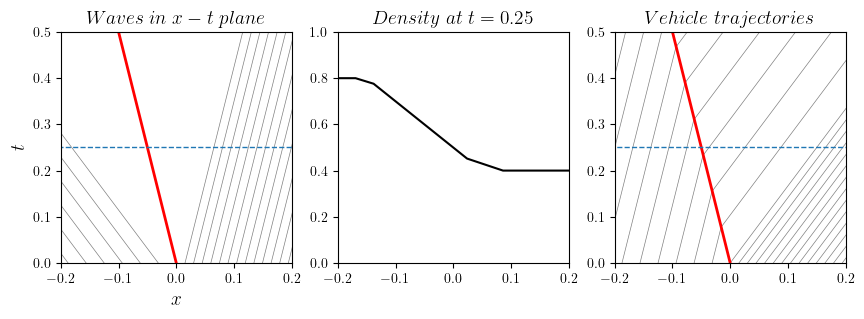

In [9]:
# Initialize the fig
nrow, ncol = 1, 3
width, height = 4.5,4 # single subplot
fig, ax = plt.subplots(nrow,ncol,figsize=(width*ncol*.75,height*.75))

# AX 0: waves in x-t plane
ax[0].plot(chars_transposed, tspan, c='k', alpha=0.5, ls='-', lw = .5)
ax[0].plot(speed_shock*tspan, tspan, c='red', ls='-', lw = 2)
ax[0].plot(xspan,t_plot*np.ones(len(xspan)), ls='--', lw = 1)

ax[0].set_xlim([-.2,.2])
ax[0].set_ylim([0, T])

# AX 1: Density
carpos_t_plot = cars_trajs_transposed[idx_t_plot]
tmp = rho(carpos_t_plot,t_plot,rho_l,rho_r, flux)
density_t_plot = np.array(tmp).flatten().tolist()

ax[1].plot(carpos_t_plot,density_t_plot, c='k', ls = '-', lw = 1.5)

ax[1].set_xlim([-.2,.2])
ax[1].set_ylim([0, 1])


# AX 2: Vehicle trajs
ax[2].plot(cars_trajs_transposed, tspan, c='k', alpha=0.5, ls='-', lw = .5)
ax[2].plot(speed_shock*tspan, tspan, c='r', ls='-', lw = 2)
ax[2].plot(xspan,t_plot*np.ones(len(xspan)), ls='--', lw = 1)

ax[2].set_xlim([-.2,.2])
ax[2].set_ylim([0, T])


# labeling     
ax[0].set_xlabel(r"$x$",fontsize=14)
ax[0].set_ylabel(r"$t$",fontsize=14)
ax[0].set_title(fr"$Waves\ in\ x-t\ plane$",fontsize=14)
ax[1].set_title(fr"$Density\ at\ t={t_plot}$",fontsize=14)
ax[2].set_title(fr"$Vehicle\ trajectories$",fontsize=14)


plt.show()

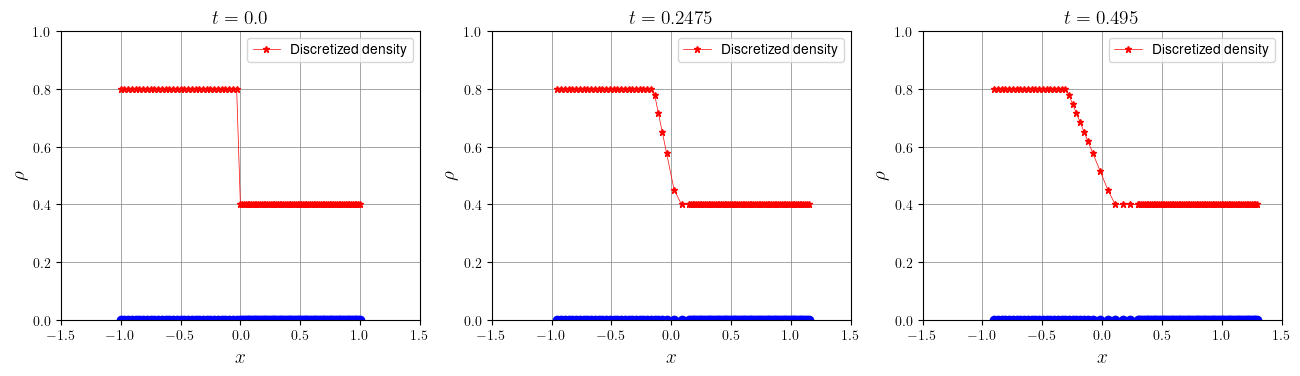

In [10]:
# Initialize the fig
nrow, ncol = 1, 3
width, height = 7, 5 # single subplot
fig, axes = plt.subplots(nrow,ncol,figsize=(width*ncol*.75,height*.75))


for step, (ax, i) in enumerate(zip(axes.ravel(), idx)):

    # X
    cars_pos = cars_trajs_transposed[i]

    # Y
    tmp = rho(cars_pos,tspan[i],rho_l,rho_r, flux)
    density = np.array(tmp).flatten().tolist()

    ax.plot(cars_trajs_transposed[i], [0]*len(cars_trajs_transposed[i]), marker='o', c='blue')
    ax.plot(cars_pos,density,c='red', ls='-', lw = 0.5, ms=5, marker='*', label="Discretized density")
    
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([0, 1])

    # labeling     
    ax.set_xlabel(r"$x$",fontsize=14)
    ax.set_ylabel(r"$\rho$",fontsize=14)
    ax.set_title(fr"$t={tspan[i]}$",fontsize=14)

    ax.grid(color='grey', linestyle='-', linewidth=0.5)
    ax.legend()
    
plt.show()